In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import anchors
import core_functions as fns
from poola import core as pool
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score

gpp.set_aesthetics(palette='Set2')


## Functions 

In [2]:
#Process data
def reformat_pDNA(df):
    '''
    Reformat pDNA 
    Input: df: original Sanjana pDNA reads  
    '''
    #sgRNA: HgLibA_00001 --> A1BG.1-A 
    new_df = df.copy()
    new_df = new_df.rename(columns = {'Guide': 'old_Guide', 'Reads':'pDNA'})
    new_guide_list = []
    gene_count = 1
    prev_gene = ''
    dummyguide_no = 1
    for i, row in enumerate(new_df.loc[:,'old_Guide']):
        gene = new_df.loc[i, 'Gene Symbol']
        if 'NonTargeting' in gene:
            gene = 'dummyguide'
            new_df.loc[i, 'Gene Symbol'] = 'dummyguide_' + str(dummyguide_no)
            dummyguide_no +=1
        if gene == prev_gene:
            gene_count +=1
        else:
            gene_count = 1
            
        guide_no = gene_count
        library = row.split('_')[0][-1]
        new_guide = gene+'.'+str(guide_no) + '-' + library
        new_guide_list.append(new_guide) 
        prev_gene = gene

    new_df['Guide'] = new_guide_list
    new_df = new_df.drop('old_Guide', axis = 1)
    new_df = new_df[['Guide', 'Gene Symbol', 'pDNA']]
    return new_df

def get_grouped_pseudogenes(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotations dataframe 
    2. control_name: list containing substrings that identify controls 
    Output:
    1. grouped_genes: controls grouped into pseudogenes with 6 randomly selected controls 
        (3 from Library A and 3 from Library B)
    '''
    #check if ungrouped df has unique identifiers for each control
    for control in control_name:
        control_condition = (df['Gene Symbol'].eq(control))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        ungrouped_df = df.copy()
            
        LibA_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('-A')].dropna()
        LibA_grouped_genes = pool.group_pseudogenes(LibA_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = [control])

        LibB_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('-B', na=False)].dropna()
        LibB_grouped_genes = pool.group_pseudogenes(LibB_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = [control])

        grouped_genes = pd.concat([LibA_grouped_genes, LibB_grouped_genes])
            
        return grouped_genes

def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs:
    1. df: reads dataframe
    2. guide_mapping: guide-gene annotation dataframe
    3. control_name: list containing substrings that identify controls
    Outputs:
    1. grouped_df: reads dataframe with controls grouped into pseudogenes 
    '''
    grouped_genes = get_grouped_pseudogenes(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

## Data Summary

* Wang et al.
* Cell line: Huh7.5.1 
* Library: GeCKOv2

In [3]:
#Read counts
reads_raw = pd.read_excel('../../Data/Reads/Puschnik/SARS_COV2_GECKO_MERGED_counts.xlsx')
reads = reads_raw[reads_raw.columns[:-2]] #drop normalized columns
reads = reads.rename(columns={'gene': 'Gene Symbol', 'sgRNA':'Guide'})

In [4]:
#pDNA reads not provided, using Sanjana GeCKOv2 pDNA reads
pDNA_reads_raw_Sanjana= pd.read_csv('../../Data/Reads/Sanjana/GSM4796722_GeckoV2plasmid.counts.txt', sep = '\t', header = None)
pDNA_reads_raw_Sanjana = pDNA_reads_raw_Sanjana.rename(columns={0: 'Guide', 1: 'Reads'})
pDNA_reads_clean_Sanjana = fns.clean_Sanjana_data(pDNA_reads_raw_Sanjana)
pDNA_reads_Sanjana = reformat_pDNA(pDNA_reads_clean_Sanjana)

guide_gene_raw = pd.read_csv('../../Data/Reads/Puschnik/Guide_seq_table_GeCKO2_combined.txt', sep = '>', header = None)
#clean guide-gene mapping df, drop NaN and align seq->guide
guide_seq= pd.DataFrame()
guide = pd.DataFrame()
guide_seq.loc[:, 'guide_seq'] = guide_gene_raw[0].dropna().reset_index(drop = True)
guide.loc[:, 'Guide'] = guide_gene_raw[1].dropna().reset_index(drop = True)
guide_gene = guide_seq.join(guide)


In [5]:
reads_all = pd.merge(pDNA_reads_Sanjana, reads, on = ['Guide'], how = 'right')
# drop column without unique dummyguide identifiers
reads_all = reads_all.drop('Gene Symbol_y', axis = 1)
reads_all =reads_all.rename(columns={'Gene Symbol_x':'Gene Symbol'})

guide_mapping = reads_all[['Guide', 'Gene Symbol']]
reads = match_pseudogenes(reads_all, guide_mapping, control_name=['dummyguide'])
reads

,Guide,Gene Symbol,pDNA,Huh751_ACE2-IRES-TMPRSS2_Gecko_control,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2
0,A1BG.1-A,A1BG,467.0,867,241
1,A1BG.2-A,A1BG,417.0,538,475
2,A1BG.3-A,A1BG,981.0,1801,216
3,A1CF.1-A,A1CF,170.0,276,104
4,A1CF.2-A,A1CF,599.0,674,66
...,...,...,...,...,...
123436,ZBED1_X.2-B,NaN,NaN,2740,1215
123437,ZBED1_X.3-B,NaN,NaN,3494,2886
123438,ZBED1_Y.1-B,NaN,NaN,2794,1071
123439,ZBED1_Y.2-B,NaN,NaN,2740,1215


In [6]:
#Calculate lognorm

cols = reads.columns[2:].to_list() #reads columns are 3rd and 4th in df
lognorms = fns.get_lognorm(reads.dropna(), cols = cols)
lognorms

,Guide,Gene Symbol,pDNA_lognorm,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lognorm,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lognorm
0,A1BG.1-A,A1BG,2.960342,2.838099,2.344720
1,A1BG.2-A,A1BG,2.819023,2.268057,3.176441
2,A1BG.3-A,A1BG,3.930627,3.784175,2.219221
3,A1CF.1-A,A1CF,1.794610,1.564637,1.464929
4,A1CF.2-A,A1CF,3.278038,2.531461,1.082185
...,...,...,...,...,...
123196,dummyguide.995-B,dummyguide_253,4.076868,2.842386,2.433293
123197,dummyguide.996-B,dummyguide_181,3.828129,2.859410,2.989217
123198,dummyguide.997-B,dummyguide_63,3.469914,3.804095,3.435384
123199,dummyguide.998-B,dummyguide_154,4.663548,3.825189,3.237270


## Quality Control
### Population Distributions

../../Figures/Huh751_GeCKOv2_popdist.png


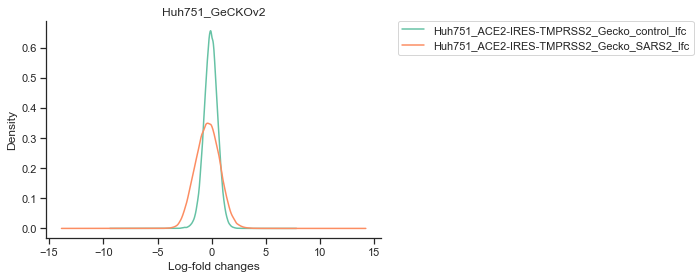

In [7]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[-2:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, initial_id = 'control', res_id = 'SARS', filename = 'Huh751_GeCKOv2')

### Control Distributions

../../Figures/Huh751_GeCKOv2_controldist.png


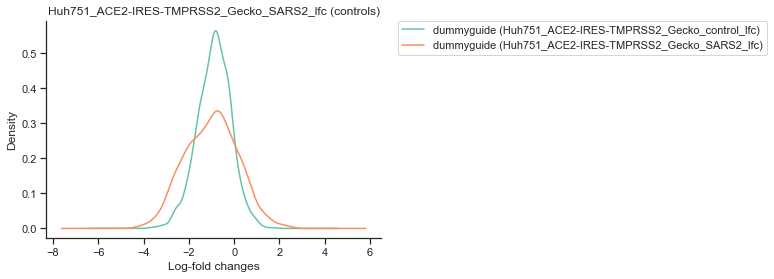

In [8]:
fns.control_dist_plot(pDNA_lfc, initial_id = 'control', res_id = 'SARS', control_name=['dummyguide'], filename = 'Huh751_GeCKOv2')

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

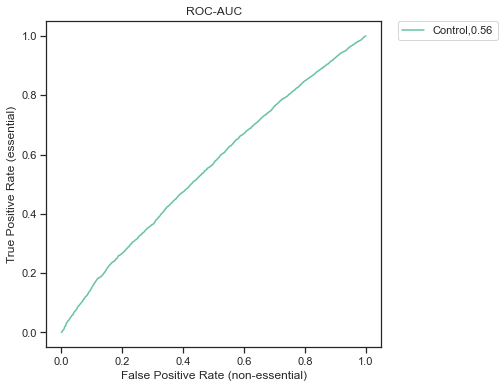

In [9]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

control_col = [col for col in pDNA_lfc.columns if 'control' in col]

roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=control_col)    

fig,ax=plt.subplots(figsize=(6,6))
ax=sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Control,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [10]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df, initial_id = 'control', res_id = 'SARS')

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)
gene_residuals

                                   modified  \
0  Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc   

                                  unperturbed  
0  Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc  


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A1BG,6,-0.388630,-0.078396,-0.051673,0.958789,0.998631
1,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A1CF,6,-0.570074,-0.198043,-0.208600,0.834761,0.994389
2,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A2M,6,-0.173488,0.009172,0.276440,0.782210,0.987715
3,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A2ML1,6,0.990566,0.088141,3.266771,0.001088,0.232647
4,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,A3GALT2,6,0.670618,0.355756,1.596300,0.110422,0.848085
...,...,...,...,...,...,...,...,...
21206,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-95,4,0.116153,0.560040,-0.417921,0.676005,0.978077
21207,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-96,4,0.389002,0.098076,1.282439,0.199689,0.897070
21208,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-98,4,-0.594006,0.133466,-1.001658,0.316509,0.924095
21209,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,hsa-mir-99a,4,0.495609,0.713639,0.070137,0.944085,0.998552


In [11]:
gene_residual_sheet= fns.format_gene_residuals(gene_residuals, guide_min = 5, guide_max = 7)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet

['Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc']


,Guide,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,A1BG.1-A,A1BG,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.196831,-0.221334,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.615622,-0.122244
1,A1BG.2-A,A1BG,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,1.220076,1.371961,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,0.357418,-0.550966
2,A1BG.3-A,A1BG,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-1.267408,-1.425186,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-1.711406,-0.146452
3,A1CF.1-A,A1CF,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,0.201145,0.226185,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.329681,-0.229973
4,A1CF.2-A,A1CF,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-1.132375,-1.273342,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-2.195854,-0.746578
...,...,...,...,...,...,...,...,...
123196,dummyguide.995-B,dummyguide_253,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.083471,-0.093862,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-1.643576,-1.234482
123197,dummyguide.996-B,dummyguide_181,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,0.451410,0.507606,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.838912,-0.968719
123198,dummyguide.997-B,dummyguide_63,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.094189,-0.105915,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-0.034530,0.334181
123199,dummyguide.998-B,dummyguide_154,Huh751_ACE2-IRES-TMPRSS2_Gecko_SARS2_lfc,-0.268922,-0.302400,Huh751_ACE2-IRES-TMPRSS2_Gecko_control_lfc,-1.426278,-0.838359


In [12]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Huh751_GeCKOv2_Puschnik.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Huh751_GeCKOv2_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Huh751_GeCKOv2_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Huh751_GeCKOv2_guide_mapping', index =False)

In [13]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Huh751_GeCKOv2_Puschnik_v2.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='gene-level_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)